In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# loading data
df_train_trans = pd.read_csv('./ieee-fraud-detection/train_transaction.csv')
df_test_trans = pd.read_csv('./ieee-fraud-detection/test_transaction.csv')

df_train_id = pd.read_csv('./ieee-fraud-detection/train_identity.csv')
df_test_id = pd.read_csv('./ieee-fraud-detection/test_identity.csv')

In [3]:
# merge identity and transaction information
df_train = df_train_trans.merge(df_train_id, on='TransactionID', how='left')
df_test = df_test_trans.merge(df_test_id, on='TransactionID', how='left')

In [4]:
print('Shape of merged training data:', df_train.shape)
print('Shape of merged testing data:', df_test.shape)

Shape of merged training data: (590540, 434)
Shape of merged testing data: (506691, 433)


## Categorical Features - Transaction
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

## Categorical Features - Identity
* DeviceType
* DeviceInfo
* id_12 - id_38

In [5]:
cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2'
           , 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
           , 'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18'
           , 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28'
           , 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

id_cols = ['TransactionID', 'TransactionDT']

label = ['isFraud']

numeric_cols = [col for col in df_train.columns.tolist() if col not in cat_cols + id_cols + label]

## Data preprocess: fill values in NA data
* For categorical data, I fill in < UNK >
* For numerical data, I fill the mean value of that column

In [6]:
df_train.loc[:,cat_cols] = df_train[cat_cols].fillna('<UNK>')
df_test.loc[:,cat_cols] = df_test[cat_cols].fillna('<UNK>')

In [7]:
df_train.loc[:,numeric_cols] = df_train[numeric_cols].fillna(value=df_train[numeric_cols].mean())
df_test.loc[:,numeric_cols] = df_test[numeric_cols].fillna(value=df_test[numeric_cols].mean())

In [8]:
# transform categorical into numerical
for col in cat_cols:
    df_train.loc[:,col] = df_train[col].astype('category').cat.codes
    df_test.loc[:,col] = df_test[col].astype('category').cat.codes

## Data exploration by visualization

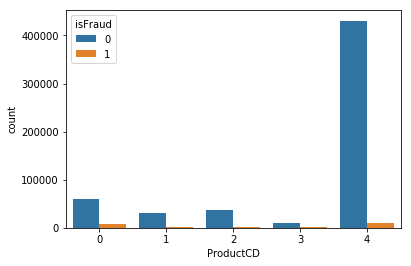

In [9]:
# visualize categorical data
sns.countplot(x='ProductCD', hue='isFraud', data=df_train)

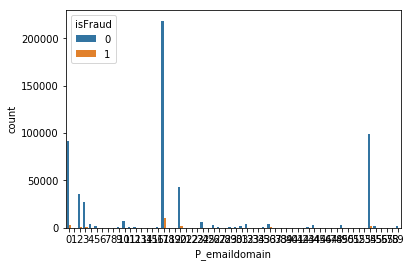

In [10]:
sns.countplot(x='P_emaildomain', hue='isFraud', data=df_train)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


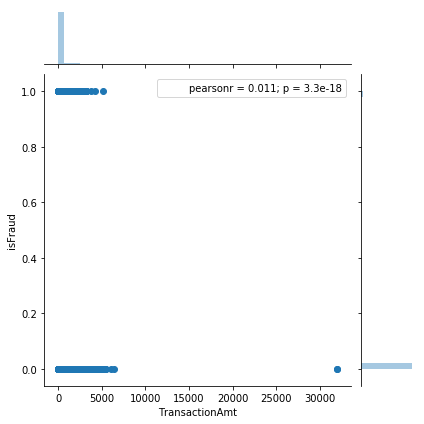

In [11]:
# visualize numerical data
sns.jointplot(x='TransactionAmt', y='isFraud', data=df_train)


## Train and test the model

In [19]:
# training and testing data split
feature_cols = cat_cols + numeric_cols

X = df_train.loc[:,feature_cols]
y = df_train.loc[:,label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [21]:
# train the model
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

print('Training accuracy:', lr.score(X_train, y_train))
print('Testing accuracy:', lr.score(X_test, y_test))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy: 0.9648312198520482
Testing accuracy: 0.9644619049231776


In [47]:
# calculate AUC and ROC for reasonable evaluation metrics
fpr_train, tpr_train, _ = metrics.roc_curve(lr.predict(X_train), y_train)
fpr_test, tpr_test, _ = metrics.roc_curve(lr.predict(X_test), y_test)

train_auc = metrics.roc_auc_score(lr.predict(X_train), y_train)
test_auc = metrics.roc_auc_score(lr.predict(X_test), y_test)

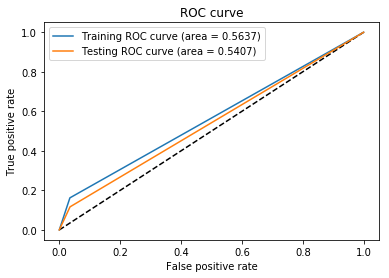

In [50]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label='Training ROC curve (area = %0.4f)' % train_auc)
plt.plot(fpr_test, tpr_test, label='Testing ROC curve (area = %0.4f)' % test_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

In [51]:
# generate prediction outputs
X_predict = df_test.loc[:,feature_cols]
y_predict = lr.predict(X_predict)

df_test['isFraud'] = y_predict
df_test[['TransactionID', 'isFraud']].to_csv('./ieee-fraud-detection/predictions.csv', index=False)